In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from uav_active_sensing.config import PROCESSED_DATA_DIR
from uav_active_sensing.pytorch_dataloaders import TinyImageNetDataset
from uav_active_sensing.modeling.env import ImageEnv
from uav_active_sensing.plots import visualize_tensor

import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from transformers import AutoImageProcessor, ViTMAEForPreTraining


/home/tcouso/.virtualenvs/uav_active_sensing/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
cifar10_processed_dir = PROCESSED_DATA_DIR / "cifar10"

cifar10_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar10_train_dataset = datasets.CIFAR10(
    root=cifar10_processed_dir, train=True, download=False, transform=cifar10_transform
)
cifar10_test_dataset = datasets.CIFAR10(
    root=cifar10_processed_dir, train=False, download=False, transform=cifar10_transform
)

cifar10_train_loader = DataLoader(cifar10_train_dataset, batch_size=1, shuffle=True)
cifar10_test_loader = DataLoader(cifar10_test_dataset, batch_size=1, shuffle=False)

In [5]:

TINY_IMAGENET_PROCESSED_DIR = PROCESSED_DATA_DIR / "tiny_imagenet/tiny-imagenet-200"

tiny_imagenet_transform = transforms.Compose([
    # transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

tiny_imagenet_train_dataset = TinyImageNetDataset(
    root_dir=TINY_IMAGENET_PROCESSED_DIR, split="train", transform=tiny_imagenet_transform
)
tiny_imagenet_val_dataset = TinyImageNetDataset(
    root_dir=TINY_IMAGENET_PROCESSED_DIR, split="val", transform=tiny_imagenet_transform
)

tiny_imagenet_train_loader = DataLoader(tiny_imagenet_train_dataset, batch_size=1, shuffle=True)
tiny_imagenet_val_loader = DataLoader(tiny_imagenet_val_dataset, batch_size=1, shuffle=False)

## Reconstruct image with trained autoencoder

In [6]:
image_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base", use_fast=True)
pretrained_model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")

In [7]:
image_processor

ViTImageProcessorFast {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessorFast",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [8]:
pretrained_model

ViTMAEForPreTraining(
  (vit): ViTMAEModel(
    (embeddings): ViTMAEEmbeddings(
      (patch_embeddings): ViTMAEPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
    )
    (encoder): ViTMAEEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTMAELayer(
          (attention): ViTMAESdpaAttention(
            (attention): ViTMAESdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTMAESelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTMAEIntermediate(
            (dense): Linear(in_features=768, out_features=

In [9]:
# From: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/ViTMAE/ViT_MAE_visualization_demo.ipynb

imagenet_mean = np.array(image_processor.image_mean)
imagenet_std = np.array(image_processor.image_std)

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def visualize(pixel_values, model, outputs):
  
  y = model.unpatchify(outputs.logits)
  y = torch.einsum('nchw->nhwc', y).detach().cpu()
  
  # visualize the mask
  mask = outputs.mask.detach()
  mask = mask.unsqueeze(-1).repeat(1, 1, model.config.patch_size**2 *3)  # (N, H*W, p*p*3)
  mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
  mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
  
  x = torch.einsum('nchw->nhwc', pixel_values)

  # masked image
  im_masked = x * (1 - mask)

  # MAE reconstruction pasted with visible patches
  im_paste = x * (1 - mask) + y * mask

  # make the plt figure larger
  plt.rcParams['figure.figsize'] = [24, 24]

  plt.subplot(1, 4, 1)
  show_image(x[0], "original")

  plt.subplot(1, 4, 2)
  show_image(im_masked[0], "masked")

  plt.subplot(1, 4, 3)
  show_image(y[0], "reconstruction")

  plt.subplot(1, 4, 4)
  show_image(im_paste[0], "reconstruction + visible")

  plt.show()

### Inputs

In [20]:
image, _ = tiny_imagenet_train_dataset[6548]
inputs = image_processor(images=image, return_tensors="pt")


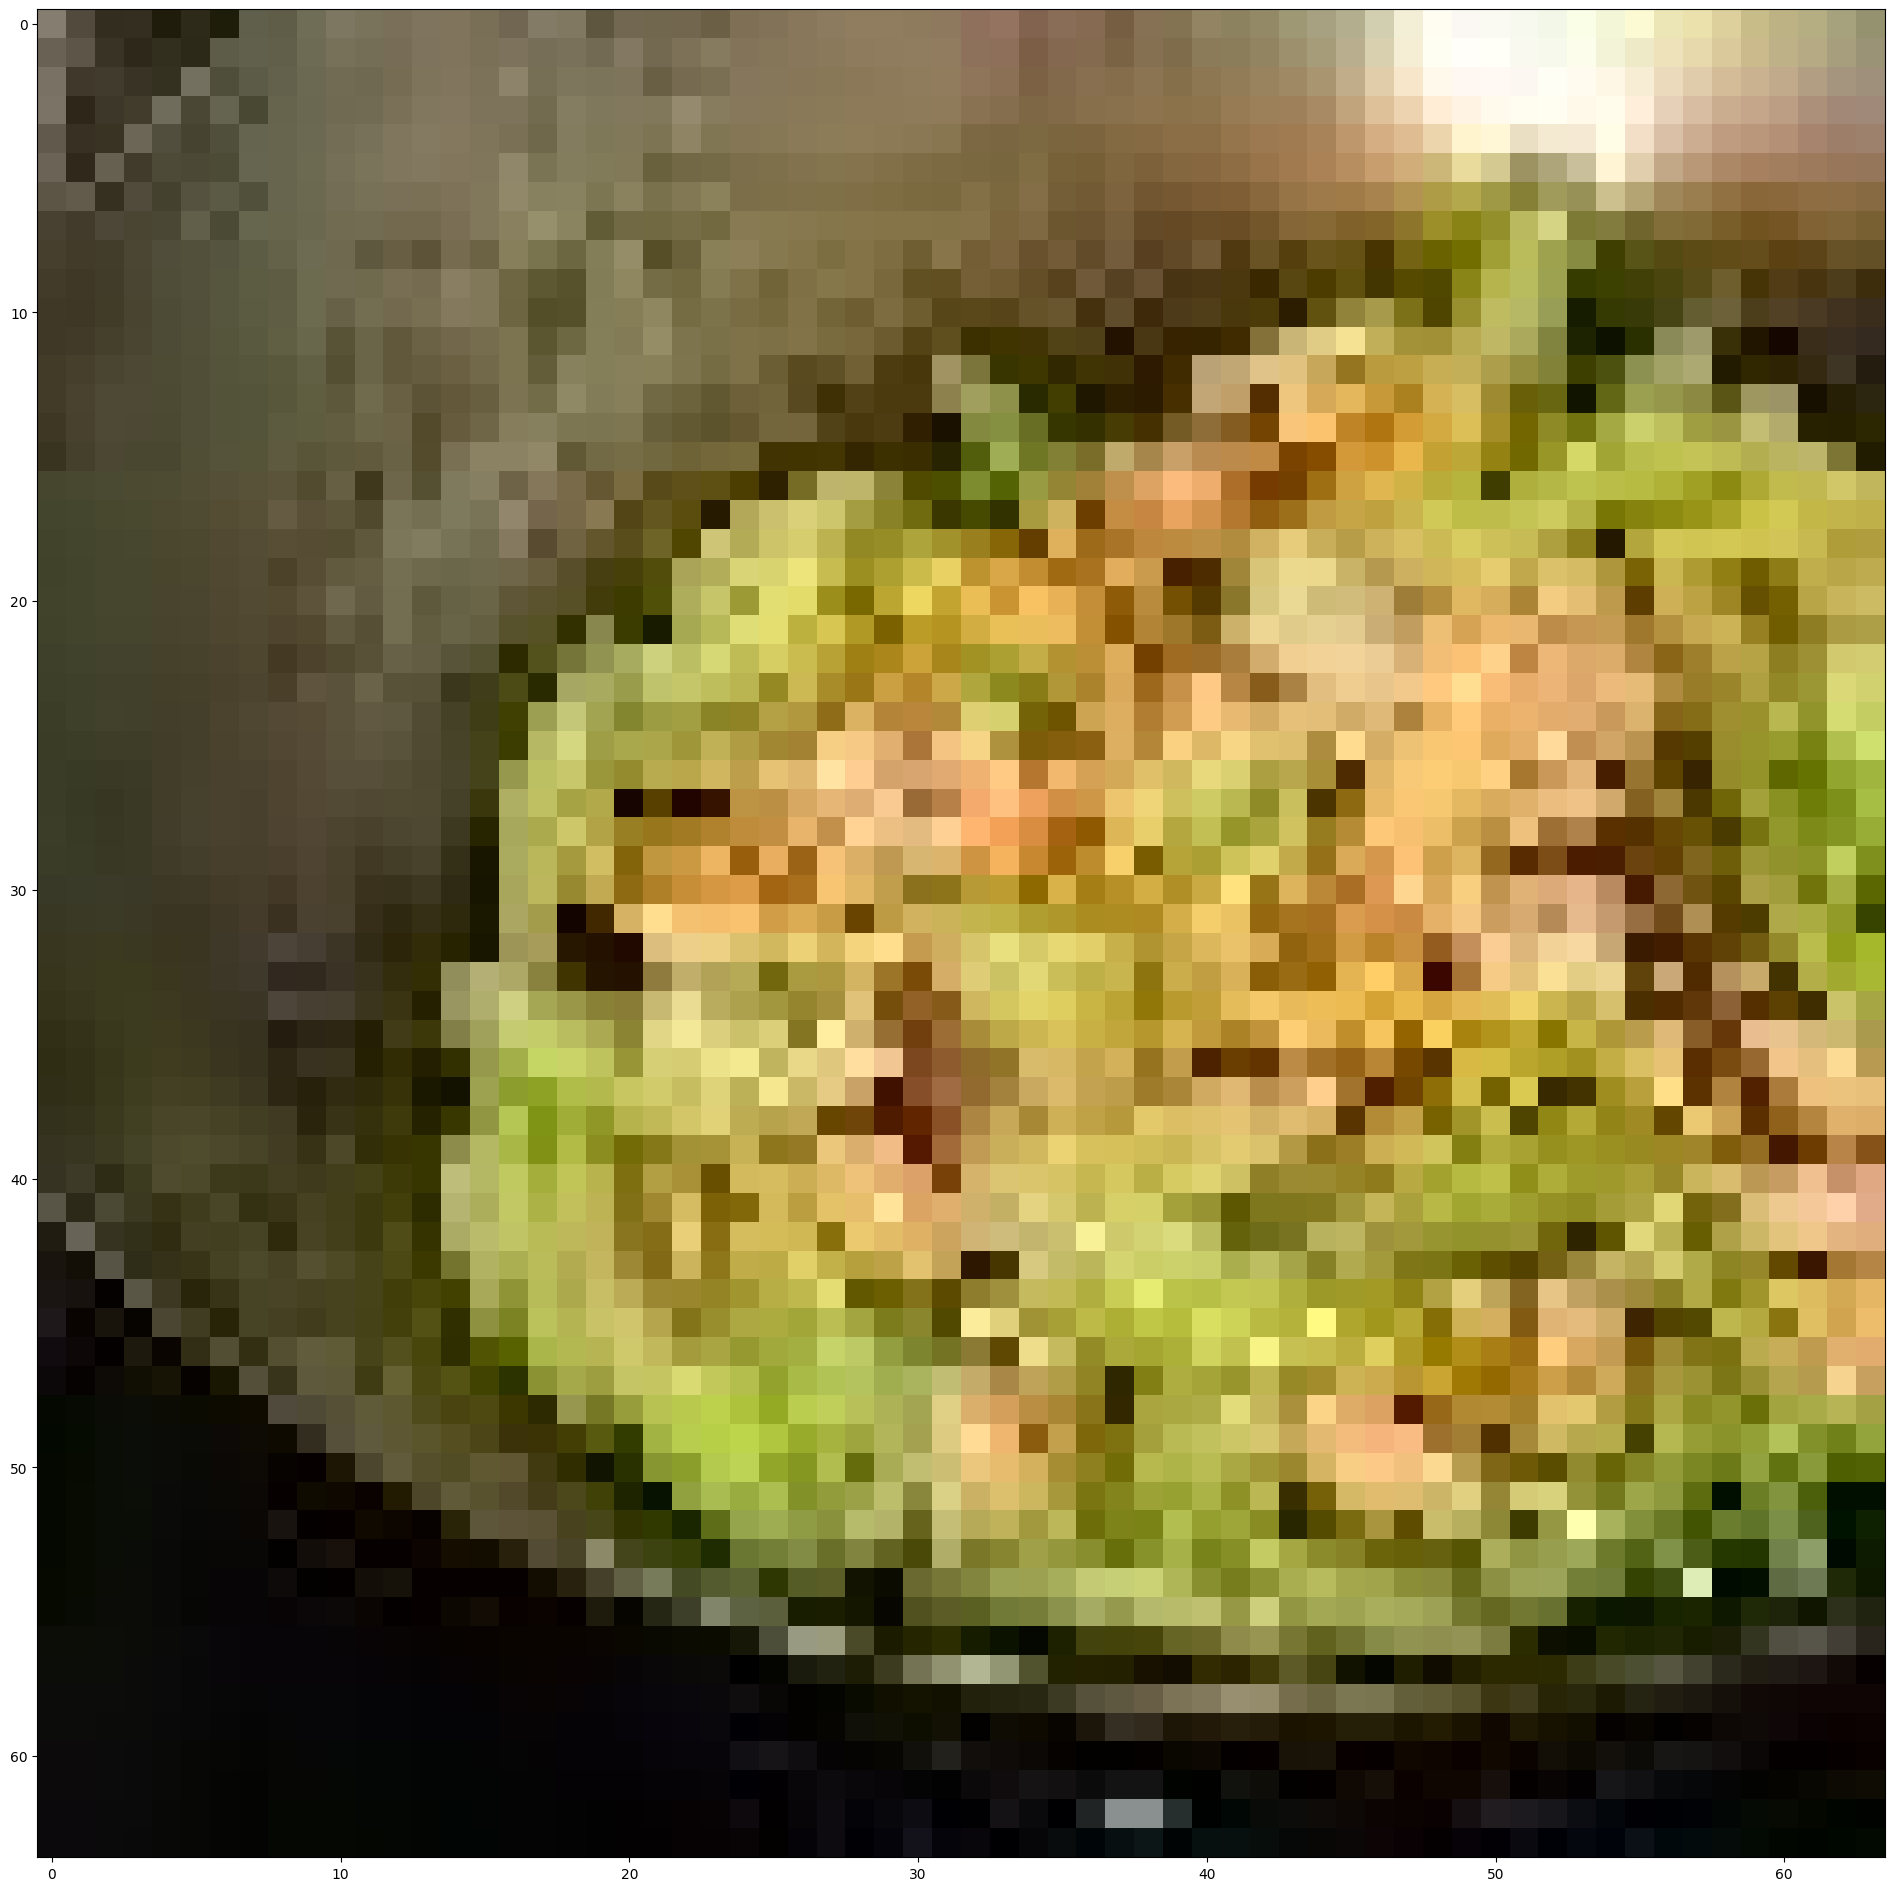

In [23]:
plt.imshow(image)

### Standard masking strategy

/tmp/ipykernel_13092/2427510520.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


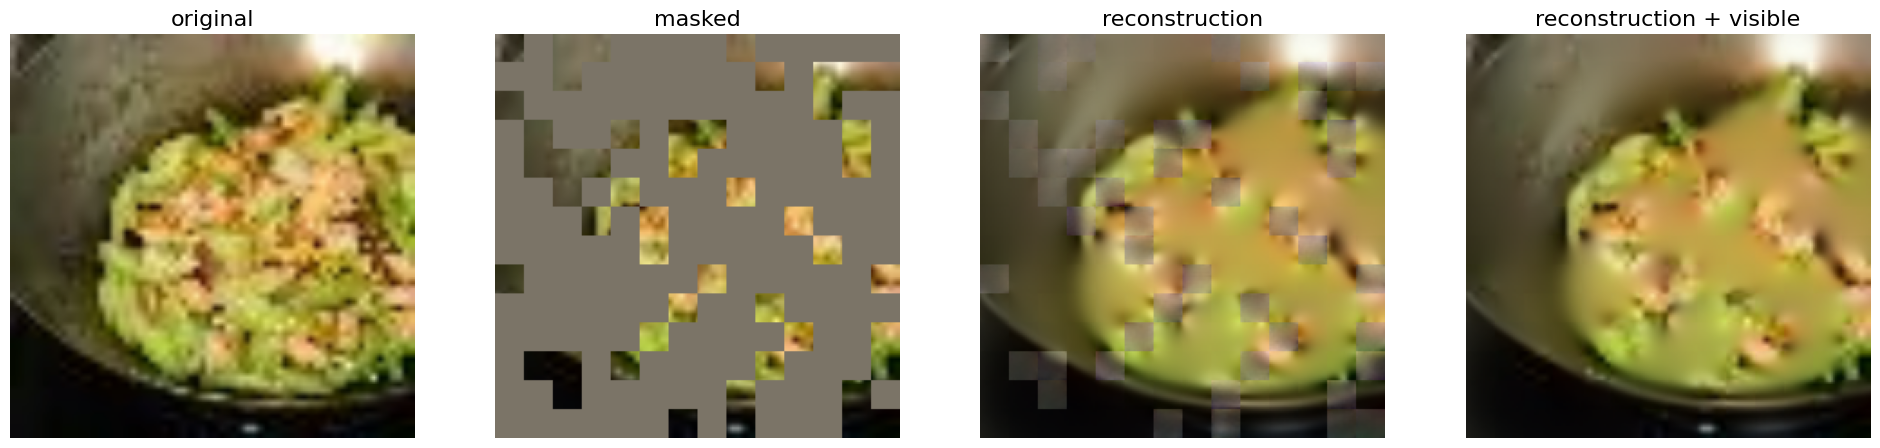

In [24]:
pretrained_outputs = pretrained_model(**inputs)
visualize(inputs.pixel_values, pretrained_model, pretrained_outputs)

In [25]:
pretrained_outputs.loss

tensor(0.1756, grad_fn=<DivBackward0>)

### Custom masking strategy

In [26]:
from uav_active_sensing.modeling.act_vit_mae import ActViTMAEForPreTraining

In [27]:
custom_model = ActViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5179956].


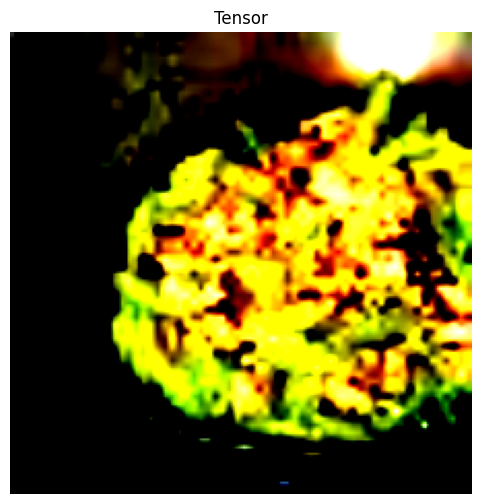

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.10078..2.1834733].


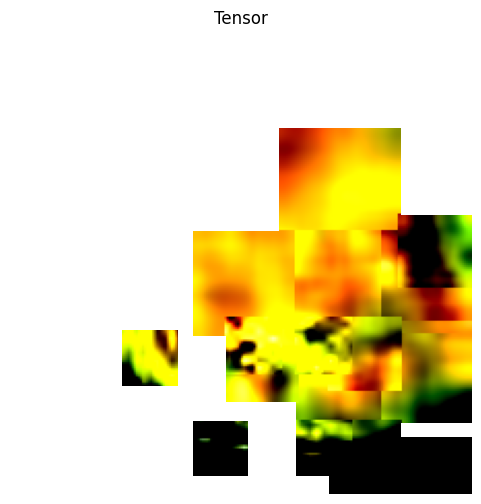

In [28]:
env = ImageEnv(inputs.pixel_values.squeeze(0), img_FoV_ratio=8)
sampled_img = env.random_walk(20, planar_step_size=50, altitude_step_size=4)

visualize_tensor(env.img)
visualize_tensor(env.sampled_img)

In [29]:
processed_image = env.img.unsqueeze(0)
processed_sampled_image = env.sampled_img.unsqueeze(0)

In [30]:
custom_outputs = custom_model(processed_image, processed_sampled_image)

/tmp/ipykernel_13092/2427510520.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


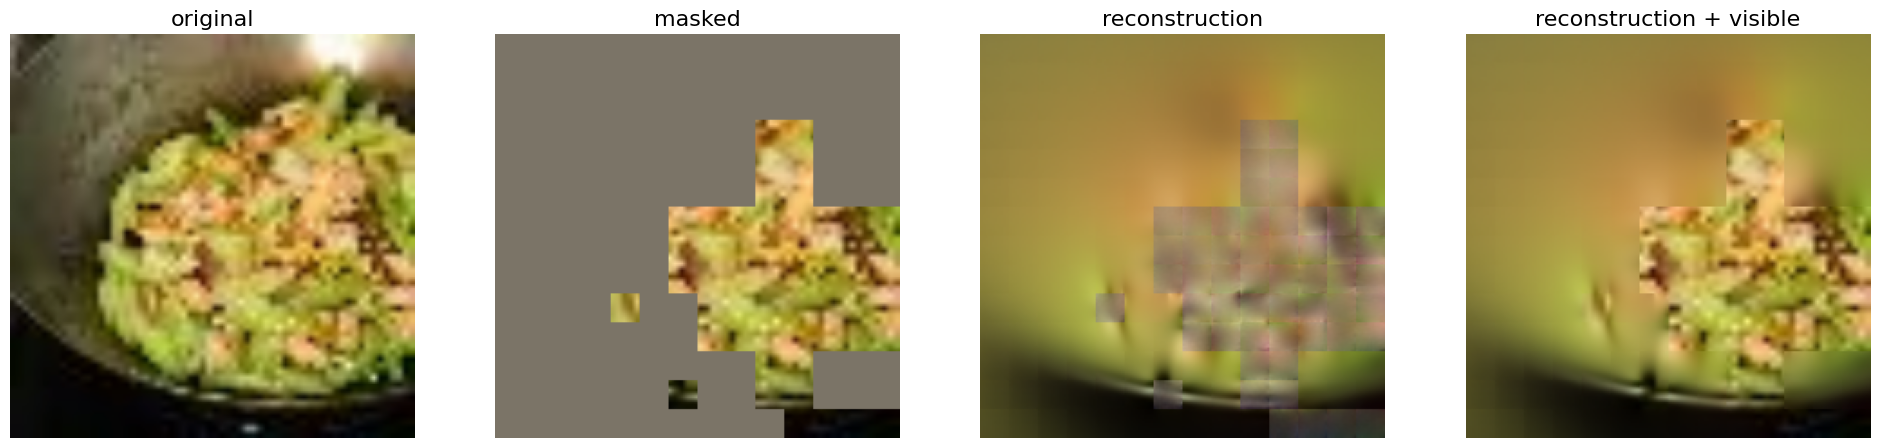

In [31]:
visualize(processed_image, custom_model, custom_outputs)